#### Competition summary:
"Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful. "

#### Requirements participating in this competition:
* Data exploration
* Feature engineering
* At least several different models built and compared to each other on the validation set and on the public and private leaderboards
* Clean code
* At least median private leaderboard score: 0.78592

#### Data composition

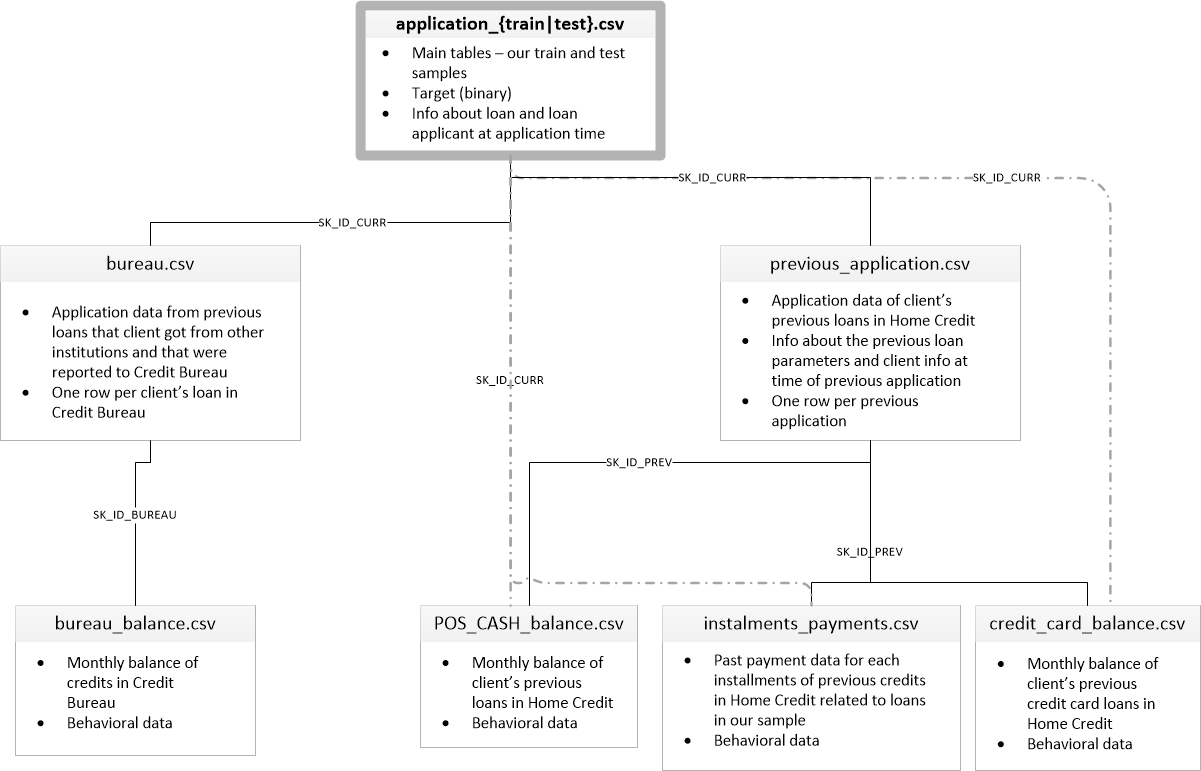

## Imports

In [1]:
%load_ext nb_black
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm

%matplotlib inline
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

### Helper functions

In [3]:
def missing_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Returns total missing data count for each feature and
    the percentage.

    Args:
        data: dataframe

    Returns:
        dataframe with missing data count
    """

    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(
        ascending=False
    )
    return pd.concat([total, percent], axis=1, keys=["Total", "Percent"])

<IPython.core.display.Javascript object>

In [54]:
def plot_stats(feature: str, label_rotation=False, horizontal_layout=True) -> None:
    """
    Returns two graphs: 
    number of contracts for the given feature 
    and percentage of target=1 (not repaired loan)

    Args:
        feature: chosen data feature to plot

    Returns:
        plot
    """

    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, "Number of contracts": temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, "TARGET"]].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by="TARGET", ascending=False, inplace=True)

    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x=feature, y="Number of contracts", data=df1)
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    s = sns.barplot(
        ax=ax2, x=feature, y="TARGET", order=cat_perc[feature], data=cat_perc
    )
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.ylabel("Percent of target with value 1 [%]", fontsize=10)
    plt.tick_params(axis="both", which="major", labelsize=10)

    plt.show()

<IPython.core.display.Javascript object>

In [55]:
def plot_b_stats(feature: str, label_rotation=False, horizontal_layout=True) -> None:
    """
    Returns two graphs: 
    number of contracts for the given feature 
    and percentage of target=1 (not repaired loan)

    Args:
        feature: chosen data feature to plot

    Returns:
        plot
    """

    temp = bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, "Number of contracts": temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = (
        bureau_train[[feature, "TARGET"]].groupby([feature], as_index=False).mean()
    )
    cat_perc.sort_values(by="TARGET", ascending=False, inplace=True)

    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x=feature, y="Number of contracts", data=df1)
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    s = sns.barplot(
        ax=ax2, x=feature, y="TARGET", order=cat_perc[feature], data=cat_perc
    )
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.ylabel("Percent of target with value 1 [%]", fontsize=10)
    plt.tick_params(axis="both", which="major", labelsize=10)

    plt.show()

<IPython.core.display.Javascript object>

In [56]:
def plot_p_stats(feature: str, label_rotation=False, horizontal_layout=True) -> None:
    """
    Returns two graphs: 
    number of contracts for the given feature 
    and percentage of target=1 (not repaired loan)

    Args:
        feature: chosen data feature to plot

    Returns:
        plot
    """

    temp = prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, "Number of contracts": temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = prev_train[[feature, "TARGET"]].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by="TARGET", ascending=False, inplace=True)

    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x=feature, y="Number of contracts", data=df1)
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    s = sns.barplot(
        ax=ax2, x=feature, y="TARGET", order=cat_perc[feature], data=cat_perc
    )
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.ylabel("Percent of target with value 1 [%]", fontsize=10)
    plt.tick_params(axis="both", which="major", labelsize=10)

    plt.show()

<IPython.core.display.Javascript object>

#### Train/test main data

* Static data for all applications. 
* One row represents one loan.
* Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [57]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
print(test.shape, train.shape)
train.head(3)

(48744, 121) (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<IPython.core.display.Javascript object>

#### Missing data

In [58]:
missing_data(train).head()

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963


<IPython.core.display.Javascript object>

## Bureau

#### Bureau

* All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan).
* For every loan there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [59]:
bureau = pd.read_csv('bureau.csv')
bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


<IPython.core.display.Javascript object>

#### Missing data

In [60]:
missing_data(bureau).head()

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932


<IPython.core.display.Javascript object>

#### Bureau balance

*  Monthly balances of previous credits in Credit Bureau.
* This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [61]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


<IPython.core.display.Javascript object>

#### Missing data

In [62]:
missing_data(bureau_balance).head()

,Total,Percent
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


<IPython.core.display.Javascript object>

## Previous home credit data

#### Credit card balance

* Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [63]:
credit_card_balance = pd.read_csv('credit_card_balance.csv')
credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


<IPython.core.display.Javascript object>

#### Missing data

In [64]:
missing_data(credit_card_balance).head()

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872


<IPython.core.display.Javascript object>

#### Installments payments

* Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
* There is a) one row for every payment that was made plus b) one row each for missed payment.
* One row is equivalent to one payment of one installment or one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [65]:
installments_payments = pd.read_csv('installments_payments.csv')
installments_payments.head(3)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


<IPython.core.display.Javascript object>

#### Missing data

In [66]:
missing_data(installments_payments).head()

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000


<IPython.core.display.Javascript object>

#### POS CASH balance

* Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [67]:
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
POS_CASH_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


<IPython.core.display.Javascript object>

#### Missing data

In [68]:
missing_data(POS_CASH_balance).head()

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000


<IPython.core.display.Javascript object>

#### Previous application

* All previous applications for Home Credit loans of clients who have loans in our sample.
* There is one row for each previous application related to loans in our data sample.

In [69]:
previous_application = pd.read_csv('previous_application.csv')
previous_application.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


<IPython.core.display.Javascript object>

#### Missing data

In [70]:
missing_data(previous_application).head()

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754


<IPython.core.display.Javascript object>

#### Summary

In [71]:
print("application_train -  rows:",train.shape[0]," columns:", train.shape[1])
print("application_test -  rows:",test.shape[0]," columns:", test.shape[1])
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bureau_balance.shape[0]," columns:", bureau_balance.shape[1])
print("credit_card_balance -  rows:",credit_card_balance.shape[0]," columns:", credit_card_balance.shape[1])
print("installments_payments -  rows:",installments_payments.shape[0]," columns:", installments_payments.shape[1])
print("previous_application -  rows:",previous_application.shape[0]," columns:", previous_application.shape[1])
print("POS_CASH_balance -  rows:",POS_CASH_balance.shape[0]," columns:", POS_CASH_balance.shape[1])

application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


<IPython.core.display.Javascript object>

## EDA

#### Main train data EDA (application train)

#### Target

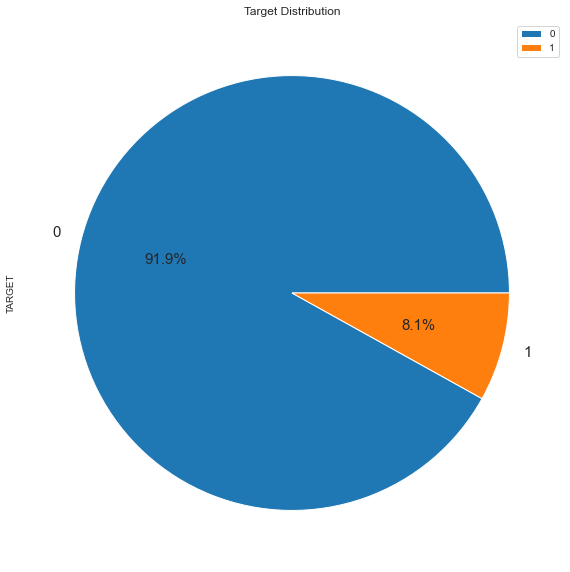

<IPython.core.display.Javascript object>

In [72]:
target_distribution = train['TARGET'].value_counts()
target_distribution.plot.pie(figsize=(10, 10),
                             title='Target Distribution', 
                             fontsize=15, 
                             legend=True, 
                             autopct=lambda v: "{:0.1f}%".format(v));

The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan). Target is disbalanced.

#### Categorical features

In [73]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

<IPython.core.display.Javascript object>

Most of the categorical variables have a relatively small number of unique entries.

##### NAME_CONTRACT_TYPE

In [74]:
pd.crosstab(train.TARGET, train.NAME_CONTRACT_TYPE, dropna=False, normalize='all')

NAME_CONTRACT_TYPE,Cash loans,Revolving loans
TARGET,,
0,0.829274,0.089997
1,0.075513,0.005216


<IPython.core.display.Javascript object>

There are two types of contract - cash loans and revolving loans. Most of the loans are cash loans which are defaulted.

##### CODE_GENDER

In [75]:
pd.crosstab(train.TARGET, train.CODE_GENDER, dropna=False)

CODE_GENDER,F,M,XNA
TARGET,,,
0,188278,94404,4
1,14170,10655,0


<IPython.core.display.Javascript object>

In [76]:
test['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

<IPython.core.display.Javascript object>

Women take more loans and higher percentage of them repays the loans. There are 4 people with unindentified gender, who repayed their loans.

##### FLAG_OWN_REALTY and FLAG_OWN_CAR

In [77]:
print('There are {0} people with realty. {1}% of them do not repay loans.'
      .format(train[train.FLAG_OWN_REALTY == 'Y'].shape[0], np.round(train[train.FLAG_OWN_REALTY == 'Y']
                                                                     .TARGET.value_counts(normalize=True).values[1], 3) * 100))
print('There are {0} people with cars. {1}% of them do not repay loans.'
      .format(train[train.FLAG_OWN_CAR == 'Y'].shape[0], np.round(train[train.FLAG_OWN_CAR == 'Y']
                                                                  .TARGET.value_counts(normalize=True).values[1], 4) * 100))

There are 213312 people with realty. 8.0% of them do not repay loans.
There are 104587 people with cars. 7.24% of them do not repay loans.


<IPython.core.display.Javascript object>

##### NAME_FAMILY_STATUS

In [78]:
pd.crosstab(train.CNT_CHILDREN, train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


<IPython.core.display.Javascript object>

In [79]:
test['NAME_FAMILY_STATUS'].unique()

array(['Married', 'Single / not married', 'Civil marriage', 'Widow',
       'Separated'], dtype=object)

<IPython.core.display.Javascript object>

Most of the people are married and have zero children.

##### NAME_TYPE_SUITE

This feature shows who was accompanying client when he was applying for the loan.

In [80]:
train['NAME_TYPE_SUITE'].value_counts(dropna=False)

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

<IPython.core.display.Javascript object>

In [81]:
pd.crosstab(train.NAME_TYPE_SUITE, train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
NAME_TYPE_SUITE,,,,,,
Children,253,1940,318,378,0,378
Family,3702,28617,1747,4150,0,1933
Group of people,29,165,20,44,0,13
Other_A,147,340,70,268,0,41
Other_B,171,854,132,486,0,127
"Spouse, partner",1247,9685,74,345,0,19
Unaccompanied,24112,154047,17334,39529,0,13504


<IPython.core.display.Javascript object>

Few variables contradict each other. For example, separated, single or widowed applicants were sometimes accompanied by their partner.

##### NAME_INCOME_TYPE

In [82]:
train.groupby(['NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count']})

AMT_INCOME_TOTAL                  
                                 mean    median   count
NAME_INCOME_TYPE                                       
Businessman             652500.000000  495000.0      10
Commercial associate    202955.327289  180000.0   71617
Maternity leave         140400.000000   90000.0       5
Pensioner               136401.292273  117000.0   55362
State servant           179737.969506  157500.0   21703
Student                 170500.000000  157500.0      18
Unemployed              110536.363636   78750.0      22
Working                 163169.889223  135000.0  158774

<IPython.core.display.Javascript object>

Unemployed/students have quite a high income. And of course, most of the people work.

In [83]:
pd.crosstab(train.NAME_INCOME_TYPE, train.OCCUPATION_TYPE, dropna=False).style.background_gradient(
    cmap='viridis', low=.5, high=0).highlight_null('red')

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Businessman,0,0,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0
Commercial associate,3970,892,1305,6528,4916,220,3495,204,12763,370,8916,1036,989,324,11104,343,1559,386
Maternity leave,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Pensioner,0,2,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
State servant,729,261,453,6956,815,64,1033,55,1868,25,2142,2585,38,9,186,264,380,53
Student,1,0,0,3,1,0,0,0,5,2,0,0,0,0,0,0,0,1
Working,5112,3498,4188,14080,12871,279,6852,267,40548,1696,10306,4915,1625,418,20811,698,4782,908


<IPython.core.display.Javascript object>

Most of applicants for loans are income from Working, followed by Commercial associate and State servant.

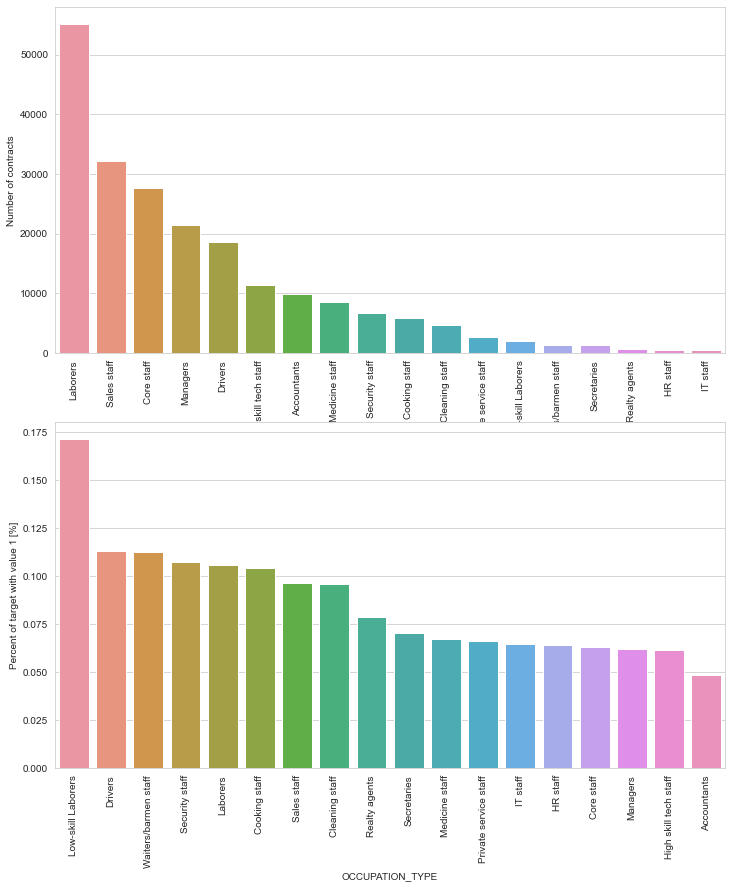

<IPython.core.display.Javascript object>

In [84]:
plot_stats('OCCUPATION_TYPE',True, False)

* Most of the loans are taken by Laborers, followed by Sales staff. IT staff take the lowest amount of loans.
* The category with highest percent of not repaid loans are Low-skill Laborers (above 17%), followed by Drivers and Waiters/barmen staff, Security staff, Laborers and Cooking staff.

##### NAME_HOUSING_TYPE

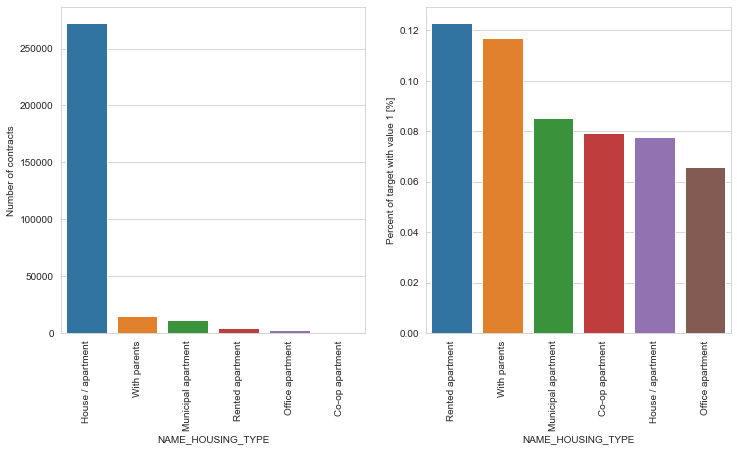

<IPython.core.display.Javascript object>

In [85]:
plot_stats('NAME_HOUSING_TYPE',True)

* Over 250,000 applicants for credits registered their housing as House/apartment. Following categories have a very small number of clients (With parents, Municipal appartment).
* From these categories, Rented apartment and With parents have higher than 10% not-repayment rate.

##### NAME_EDUCATION_TYPE

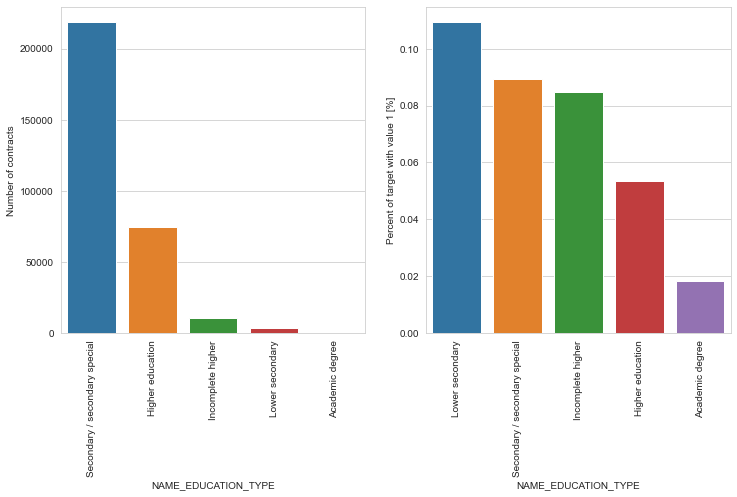

<IPython.core.display.Javascript object>

In [86]:
plot_stats('NAME_EDUCATION_TYPE',True)

* Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.
* The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.

##### ORGANIZATION_TYPE

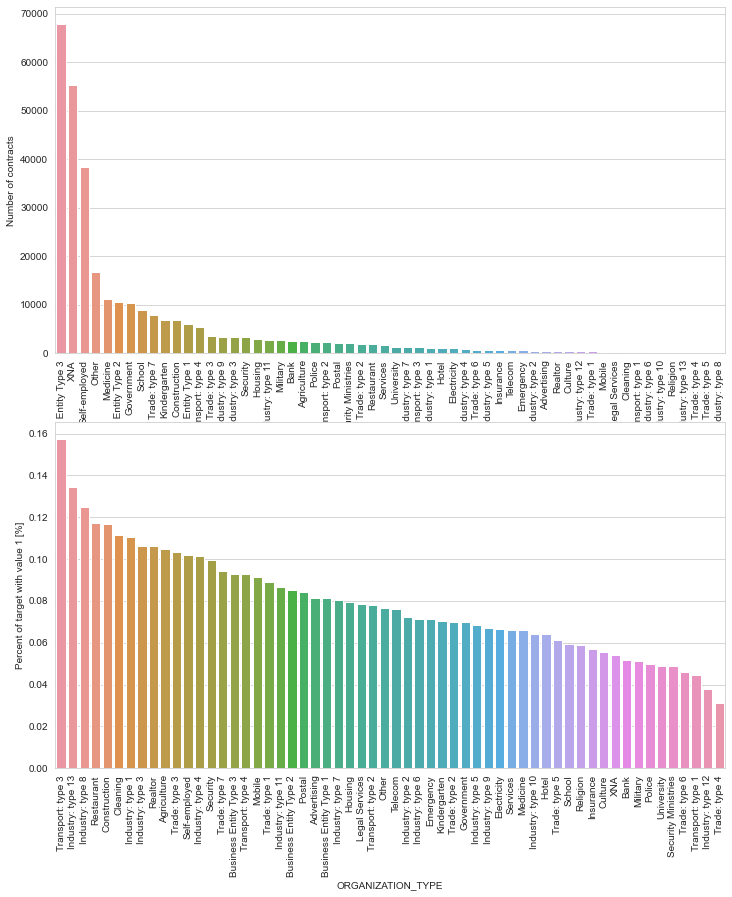

<IPython.core.display.Javascript object>

In [87]:
plot_stats('ORGANIZATION_TYPE',True, False)

Oraganizations with highest percent of loans not repaid are Transport: type 3 (16%), Industry: type 13 (13.5%), Industry: type 8 (12.5%) and Restaurant (less than 12%).

### Numerical features

In [88]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

<IPython.core.display.Javascript object>

##### Distributions for some features

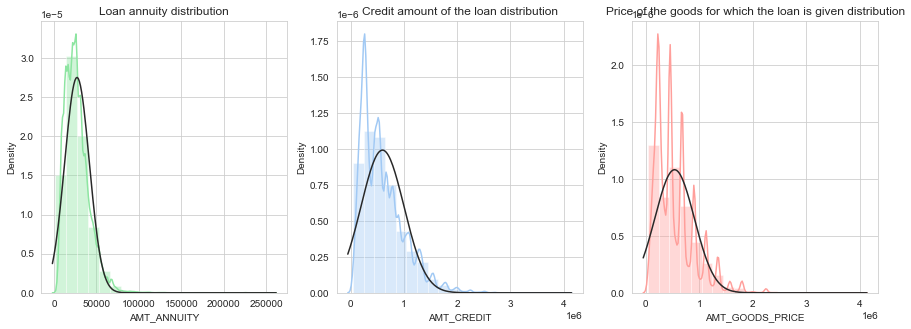

<IPython.core.display.Javascript object>

In [89]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(train.AMT_ANNUITY.dropna(), kde=True, color="g", ax=axes[0], bins=20, fit=norm).set_title('Loan annuity distribution'); 
sns.distplot(train.AMT_CREDIT.dropna(), kde=True, color="b", ax=axes[1], bins=20, fit=norm).set_title('Credit amount of the loan distribution');
sns.distplot(train.AMT_GOODS_PRICE.dropna(), kde=True, color="r", ax=axes[2], bins=20, fit=norm).set_title('Price of the goods for which the loan is given distribution');

* Average distributon for loan annuity is from 0 to 75000
* Credit amount of the loan and price of the goods for which the loan is given distributions are from 0 to 1000000

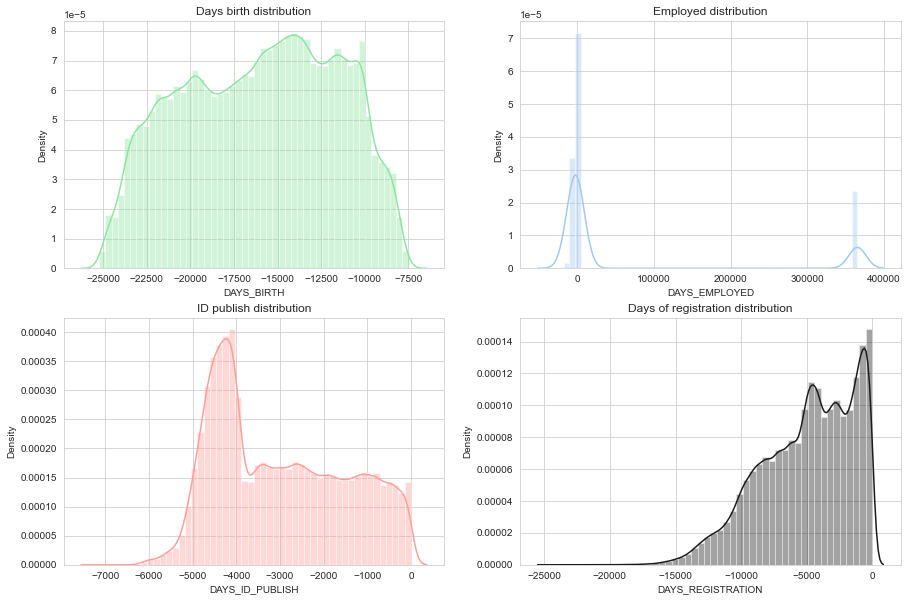

<IPython.core.display.Javascript object>

In [90]:
sns.set_style('whitegrid')
f, ax = plt.subplots(2,2, figsize=(15, 10))
sns.distplot(train.DAYS_BIRTH.dropna(), kde=True, color="g", ax=ax[0,0]).set_title('Days birth distribution');
sns.distplot(train.DAYS_EMPLOYED.dropna(), kde=True, color="b", ax=ax[0,1]).set_title('Employed distribution');
sns.distplot(train.DAYS_ID_PUBLISH.dropna(), kde=True, color="r", ax=ax[1,0]).set_title('ID publish distribution');
sns.distplot(train.DAYS_REGISTRATION.dropna(), kde=True, color="k", ax=ax[1,1]).set_title('Days of registration distribution');

In [91]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

<IPython.core.display.Javascript object>

* Days ID published, days registration and days of birth negative value means that the events happened in the past. 
* To see these stats in years for days birth, we can mutliple by -1 and divide by the number of days in a year: The age range is between approximative 20 and 69 years.
* Days employed negative values most probably means unemployed. It is not clear what will be the meaning of the very large numbers at the far end (it is not realistic such a large set of people employed more than 100 years).

### Correlations

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

#### Correlations with the target

In [92]:
correlations = train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


<IPython.core.display.Javascript object>

DAYS_BIRTH is the most positive correlation. The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (the target == 0). Will take absolute value of the feature and then the correlation will be negative.

In [93]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982712

<IPython.core.display.Javascript object>

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

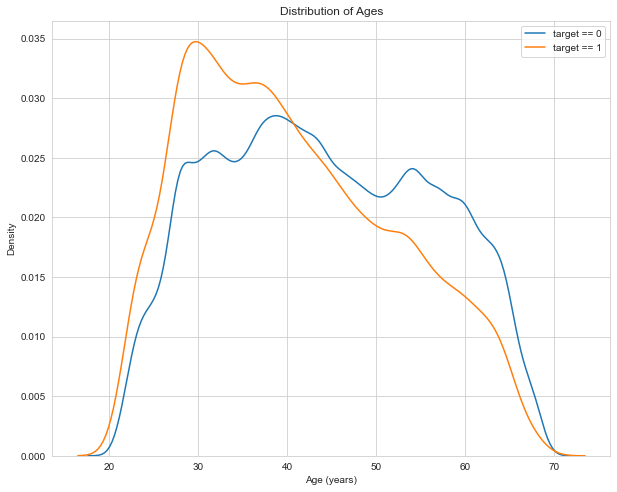

<IPython.core.display.Javascript object>

In [94]:
plt.figure(figsize = (10, 8))
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend();

##### The ratio of loans that were not repaid in each age category

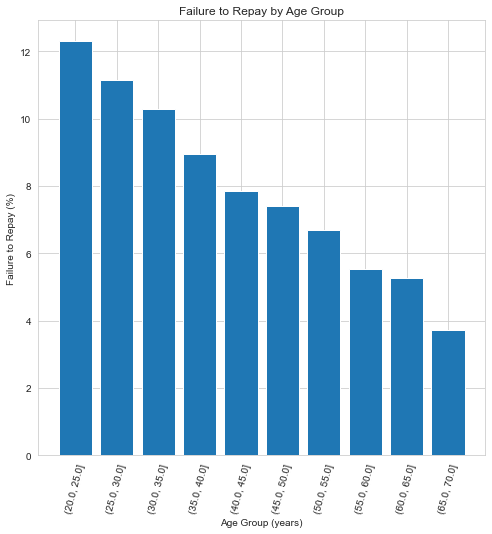

<IPython.core.display.Javascript object>

In [95]:
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Older people tend to pay loans more often. The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

### Credit card balance data

##### Averages

In [96]:
df_with_cc_info = pd.merge(train, credit_card_balance, on="SK_ID_CURR", how="right")
df_mean = df_with_cc_info.groupby(["TARGET"]).mean()
df_with_cc_info = df_with_cc_info.groupby(["SK_ID_CURR", "TARGET"]).mean().reset_index()

<IPython.core.display.Javascript object>

In [97]:
df_mean[["AMT_DRAWINGS_CURRENT", "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL", "AMT_TOTAL_RECEIVABLE"]]

,AMT_DRAWINGS_CURRENT,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_TOTAL_RECEIVABLE
TARGET,,,,
0.0,7283.544427,57593.932362,152326.788614,57405.421900
1.0,10238.370369,78356.503121,161123.462507,77996.429909


<IPython.core.display.Javascript object>

* AMT_CREDIT_LIMIT_ACTUAL mean is almost equal.
* Other values are slightly higher for the 1.0.

### Previous application data

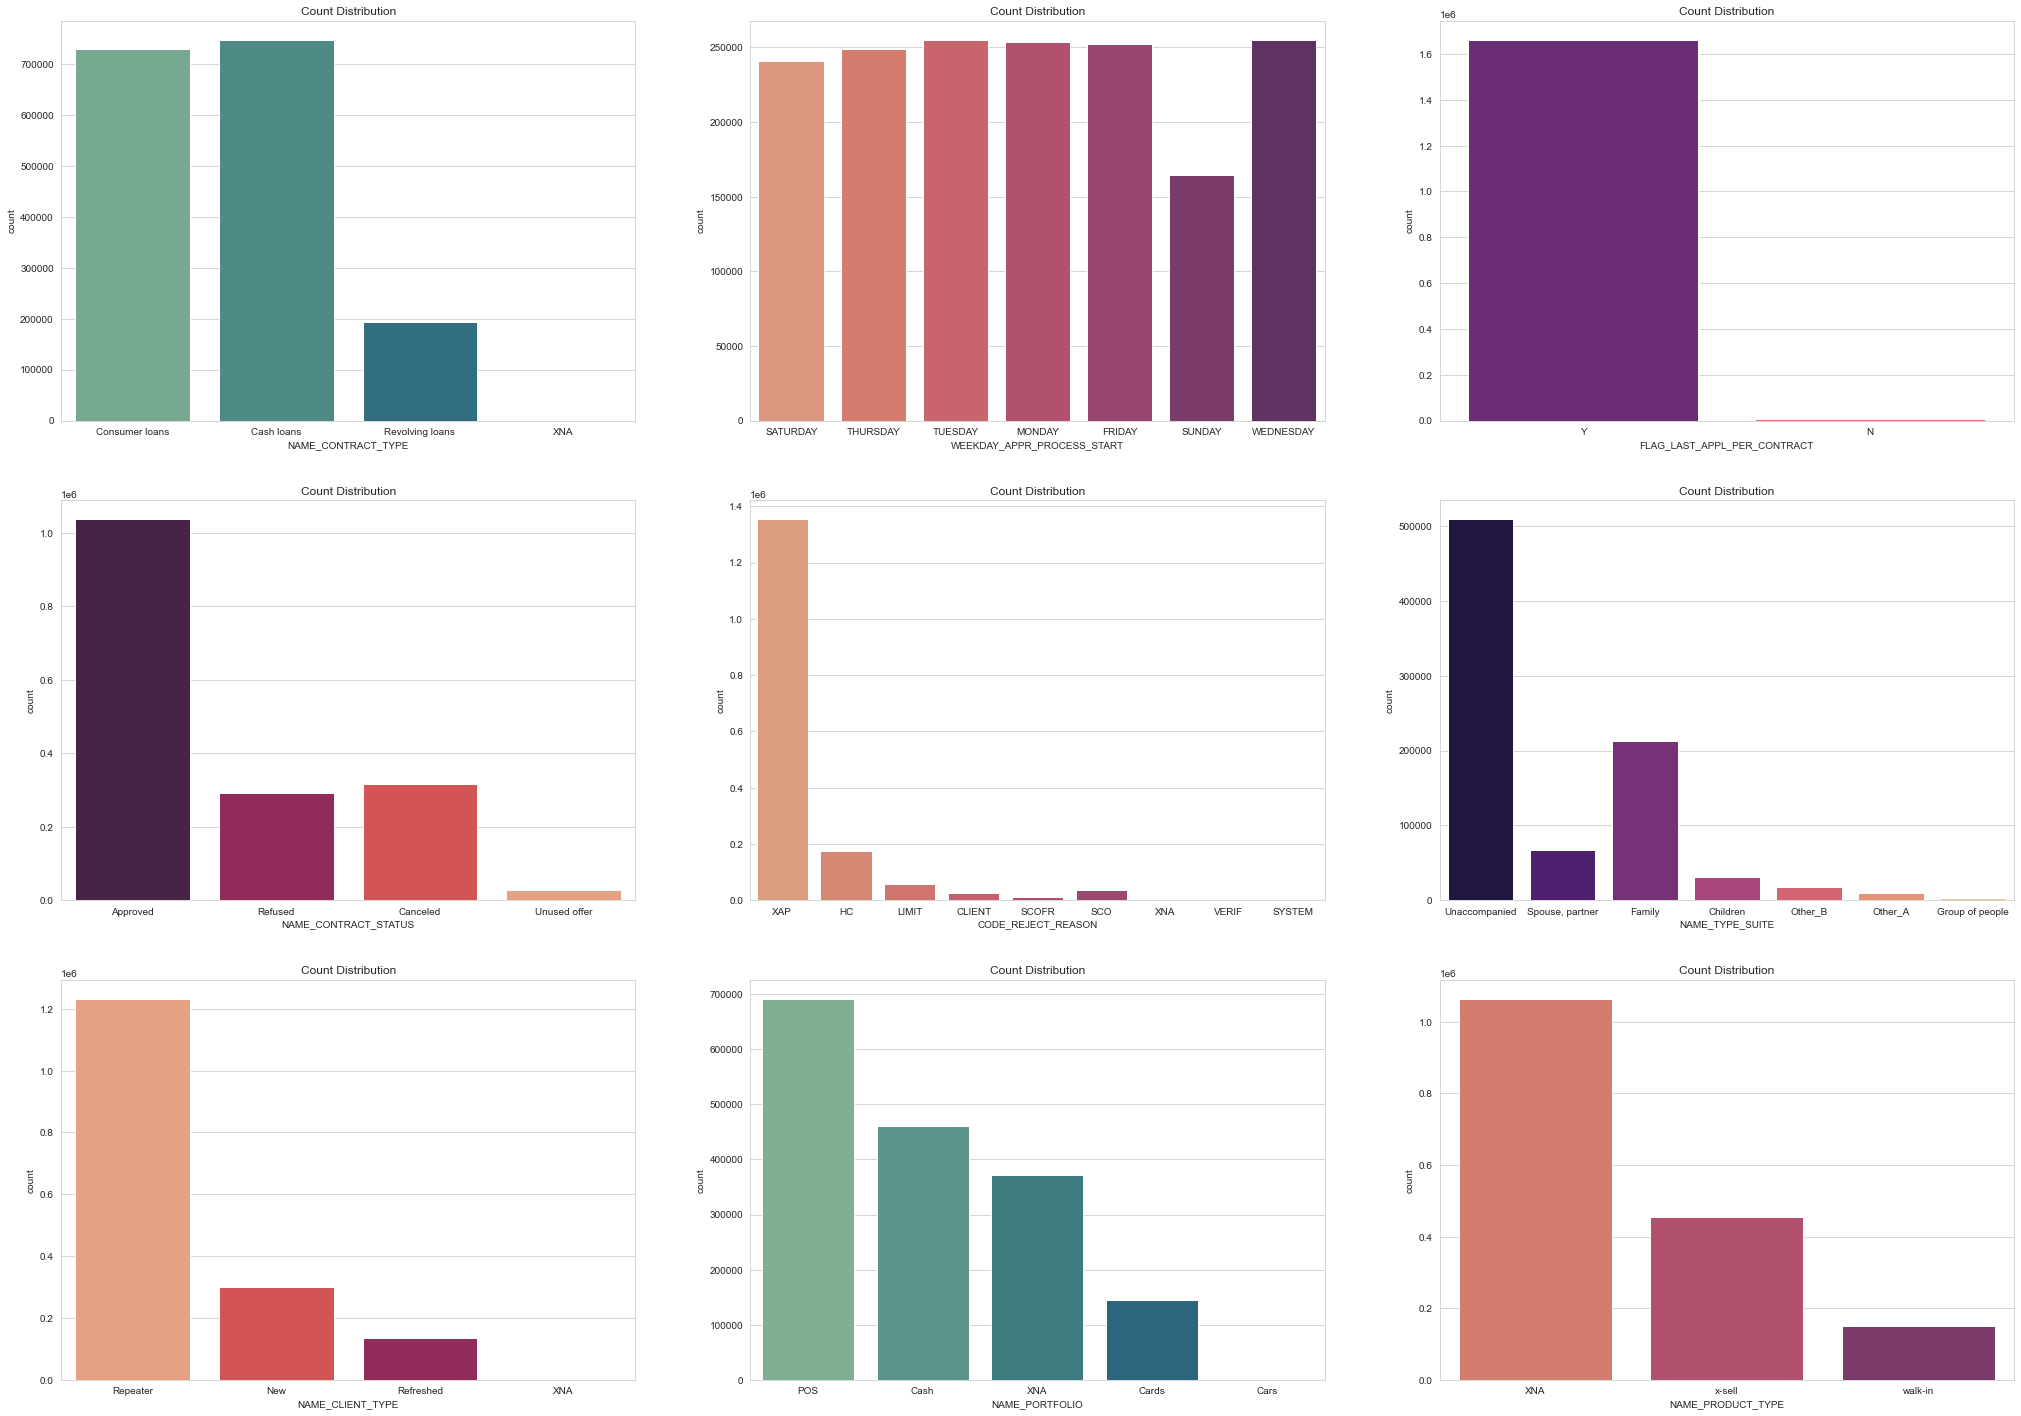

<IPython.core.display.Javascript object>

In [98]:
f, ax = plt.subplots(3,3,figsize=(35,25))
sns.countplot(previous_application.NAME_CONTRACT_TYPE.dropna(), palette='crest', ax=ax[0,0]).set_title('Count Distribution');
sns.countplot(previous_application.WEEKDAY_APPR_PROCESS_START.dropna(), palette='flare', ax=ax[0,1]).set_title('Count Distribution');
sns.countplot(previous_application.FLAG_LAST_APPL_PER_CONTRACT.dropna(), palette='magma', ax=ax[0,2]).set_title('Count Distribution');
sns.countplot(previous_application.NAME_CONTRACT_STATUS.dropna(), palette='rocket', ax=ax[1,0]).set_title('Count Distribution');
sns.countplot(previous_application.CODE_REJECT_REASON.dropna(), palette='flare', ax=ax[1,1]).set_title('Count Distribution');
sns.countplot(previous_application.NAME_TYPE_SUITE.dropna(), palette='magma', ax=ax[1,2]).set_title('Count Distribution');
sns.countplot(previous_application.NAME_CLIENT_TYPE.dropna(), palette='rocket_r', ax=ax[2,0]).set_title('Count Distribution');
sns.countplot(previous_application.NAME_PORTFOLIO.dropna(), palette='crest', ax=ax[2,1]).set_title('Count Distribution');
sns.countplot(previous_application.NAME_PRODUCT_TYPE.dropna(), palette='flare', ax=ax[2,2]).set_title('Count Distribution');

By looking at the above given plot its clear that which types has high count in each feature so we can easy out the root cause of the problem

In [99]:
prev_train = train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
print("The resulting dataframe `application_prev_train` has ",prev_train.shape[0]," rows and ", 
      prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


<IPython.core.display.Javascript object>

##### NAME_CONTRACT_STATUS

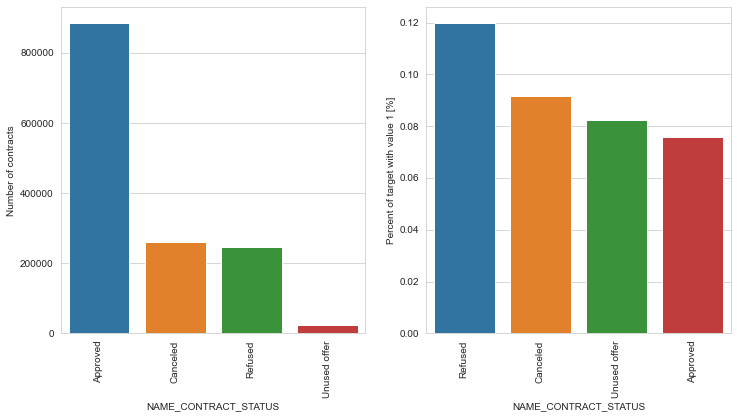

<IPython.core.display.Javascript object>

In [100]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

* Most previous applications contract statuses are Approved, Canceled and Refused. There are only ~20K in status Unused offer.
* In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are Refused (12%), followed by Canceled (9%), Unused offer (~8%) and Approved (lowest percent of defaults in current applictions, with less than 8%).

##### NAME_CLIENT_TYPE

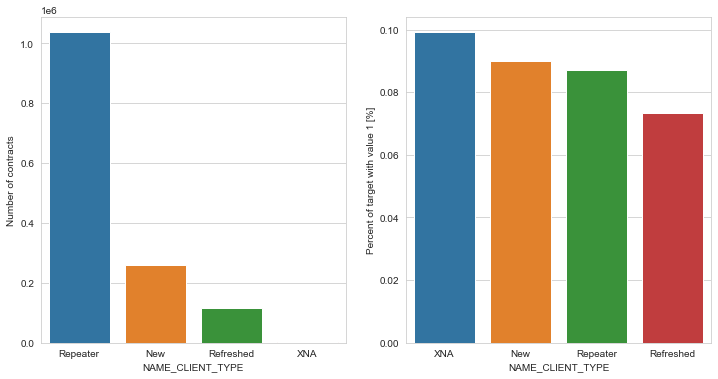

<IPython.core.display.Javascript object>

In [101]:
plot_p_stats('NAME_CLIENT_TYPE')

* Most of the previous applications have client type Repeater (~1M), just over 200K are New and ~100K are Refreshed.
* In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past New, Repeater and Refreshed, respectivelly.

### Bureau data

In [102]:
bureau_train = train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
print("The resulting dataframe `bureau_train` has ",bureau_train.shape[0]," rows and ", 
      bureau_train.shape[1]," columns.")

The resulting dataframe `bureau_train` has  1465325  rows and  138  columns.


<IPython.core.display.Javascript object>

##### CREDIT_ACTIVE

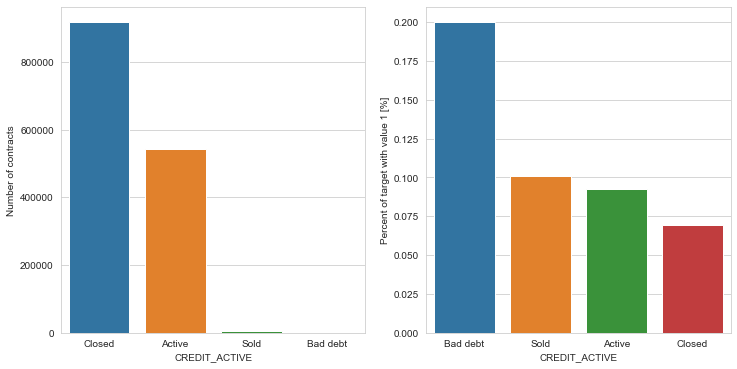

<IPython.core.display.Javascript object>

In [103]:
plot_b_stats('CREDIT_ACTIVE')

* Most of the credits registered at the Credit Bureau are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few.
* In the same time, as percent having TARGET = 1 from total number per category, clients with credits registered to the Credit Bureau with Bad debt have 20% default on the currrent applications.
* Clients with credits Sold, Active and Closed have percent of TARGET == 1 (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with Closed credits.
* That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of Bad debt is twice as large as for Sold or Active and almost three times larger as for Closed.

##### Duration of credit (DAYS_CREDIT)

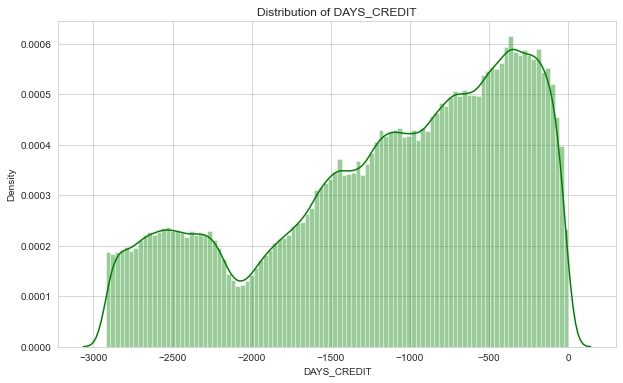

<IPython.core.display.Javascript object>

In [104]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

##### AMT_CREDIT_SUM

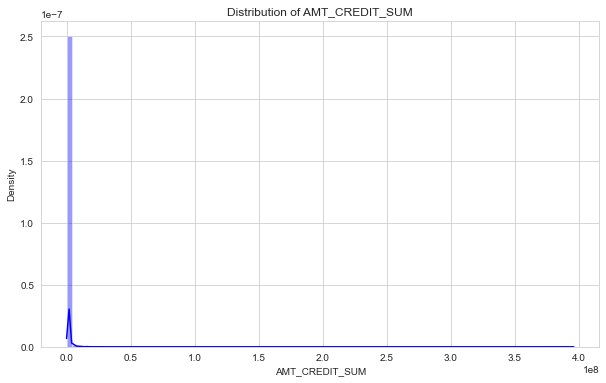

<IPython.core.display.Javascript object>

In [105]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

* The distribution of the AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range.
* Will remove the outliers so that we can see better the distribution around 0.

In [106]:
def is_outlier(points, thresh=3.5) -> None:
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Args:
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.
            
    Returns:
        A numobservations-length boolean array.
    """
    
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

<IPython.core.display.Javascript object>

In [107]:
def plot_b_o_distribution(feature: str,color) -> None:
    """
    Plots AMT_CREDIT_SUM distribution.
    
    Args: 
       feature
    
    Returns:   
        distribution plot
    """

    plt.title("Distribution of %s" % feature)
    x = bureau_train[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 

<IPython.core.display.Javascript object>

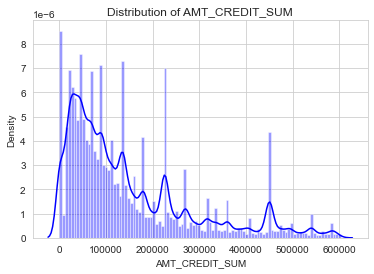

<IPython.core.display.Javascript object>

In [108]:
plot_b_o_distribution('AMT_CREDIT_SUM','blue')

Distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.